In [1]:
!pip install tensorflow-gpu==2.0.0-alpha0

     |████████████████████████████████| 332.1MB 52kB/s 
     |████████████████████████████████| 3.0MB 41.4MB/s 
     |████████████████████████████████| 419kB 52.0MB/s 


In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.python.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or 

In [0]:
# Data comes from:
# https://finance.yahoo.com/quote/BTC-USD/history?period1=1279314000&period2=1556053200&interval=1d&filter=history&frequency=1d

csv_path = "https://raw.githubusercontent.com/curiousily/Deep-Learning-For-Hackers/master/data/3.stock-prediction/BTC-USD.csv"
# csv_path = "https://raw.githubusercontent.com/curiousily/Deep-Learning-For-Hackers/master/data/3.stock-prediction/AAPL.csv"

In [0]:
df = pd.read_csv(csv_path, parse_dates=['Date'])

In [0]:
df = df.sort_values('Date')

In [6]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-07-16,0.04951,0.04951,0.04951,0.04951,0.04951,0
1,2010-07-17,0.04951,0.08585,0.05941,0.08584,0.08584,5
2,2010-07-18,0.08584,0.09307,0.07723,0.08080,0.08080,49
3,2010-07-19,0.08080,0.08181,0.07426,0.07474,0.07474,20
4,2010-07-20,0.07474,0.07921,0.06634,0.07921,0.07921,42


In [7]:
df.shape

(3201, 7)

Text(0, 0.5, 'Close Price (USD)')

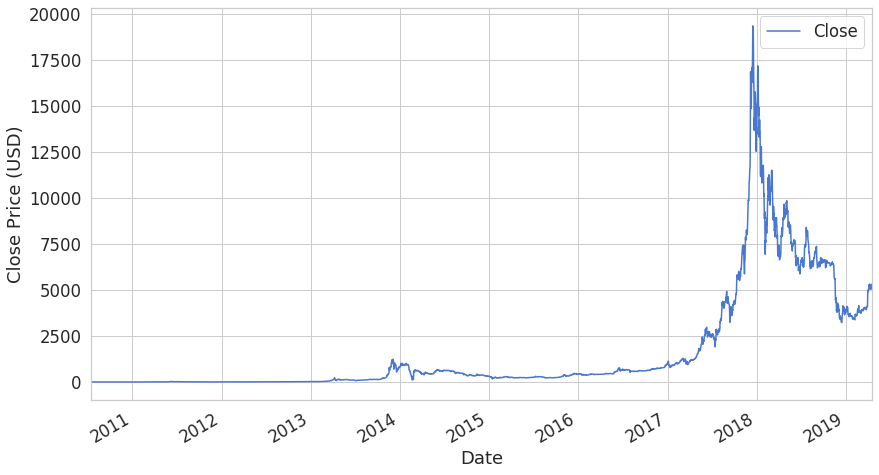

In [8]:
ax = df.plot(x='Date', y='Close');
ax.set_xlabel("Date")
ax.set_ylabel("Close Price (USD)")

# Normalization

In [0]:
scaler = MinMaxScaler()

close_price = df.Close.values.reshape(-1, 1)

scaled_close = scaler.fit_transform(close_price)

In [10]:
scaled_close.shape

(3201, 1)

In [11]:
np.isnan(scaled_close).any()

False

In [0]:
scaled_close = scaled_close[~np.isnan(scaled_close)]

In [0]:
scaled_close = scaled_close.reshape(-1, 1)

In [14]:
np.isnan(scaled_close).any()

False

# Preprocessing

In [0]:
SEQ_LEN = 100

def to_sequences(data, seq_len):
    d = []

    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])

    return np.array(d)

def preprocess(data_raw, seq_len, train_split):

    data = to_sequences(data_raw, seq_len)

    num_train = int(train_split * data.shape[0])

    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]

    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]

    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test = preprocess(scaled_close, SEQ_LEN, train_split = 0.95)

In [16]:
X_train.shape

(2945, 99, 1)

In [17]:
X_test.shape

(156, 99, 1)

# Model

In [0]:
DROPOUT = 0.2
WINDOW_SIZE = SEQ_LEN - 1

model = keras.Sequential()

model.add(Bidirectional(CuDNNLSTM(WINDOW_SIZE, return_sequences=True),
                        input_shape=(WINDOW_SIZE, X_train.shape[-1])))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(CuDNNLSTM((WINDOW_SIZE * 2), return_sequences=True)))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(CuDNNLSTM(WINDOW_SIZE, return_sequences=False)))

model.add(Dense(units=1))

model.add(Activation('linear'))

# Training

In [0]:
model.compile(
    loss='mean_squared_error', 
    optimizer='adam'
)

In [20]:
BATCH_SIZE = 64

history = model.fit(
    X_train, 
    y_train, 
    epochs=50, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    validation_split=0.1
)

Train on 2650 samples, validate on 295 samples
Epoch 1/50
2650/2650 [==============================] - 13s 5ms/sample - loss: 0.0060 - val_loss: 0.0588
Epoch 2/50
2650/2650 [==============================] - 7s 3ms/sample - loss: 0.0154 - val_loss: 0.0297
Epoch 3/50
2650/2650 [==============================] - 6s 2ms/sample - loss: 0.0137 - val_loss: 0.0059
Epoch 4/50
2650/2650 [==============================] - 6s 2ms/sample - loss: 0.0148 - val_loss: 0.0603
Epoch 5/50
2650/2650 [==============================] - 6s 2ms/sample - loss: 0.0163 - val_loss: 0.0267
Epoch 6/50
2650/2650 [==============================] - 6s 2ms/sample - loss: 0.0247 - val_loss: 0.0563
Epoch 7/50
2650/2650 [==============================] - 6s 2ms/sample - loss: 0.0183 - val_loss: 0.0678
Epoch 8/50
2650/2650 [==============================] - 6s 2ms/sample - loss: 0.0093 - val_loss: 0.0214
Epoch 9/50
2650/2650 [==============================] - 6s 2ms/sample - loss: 0.0115 - val_loss: 0.0265
Epoch 10/50
2650

In [0]:
model.evaluate(X_test, y_test)

156/156 [==============================] - 0s 1ms/sample - loss: 0.0016


0.0015700155860171295

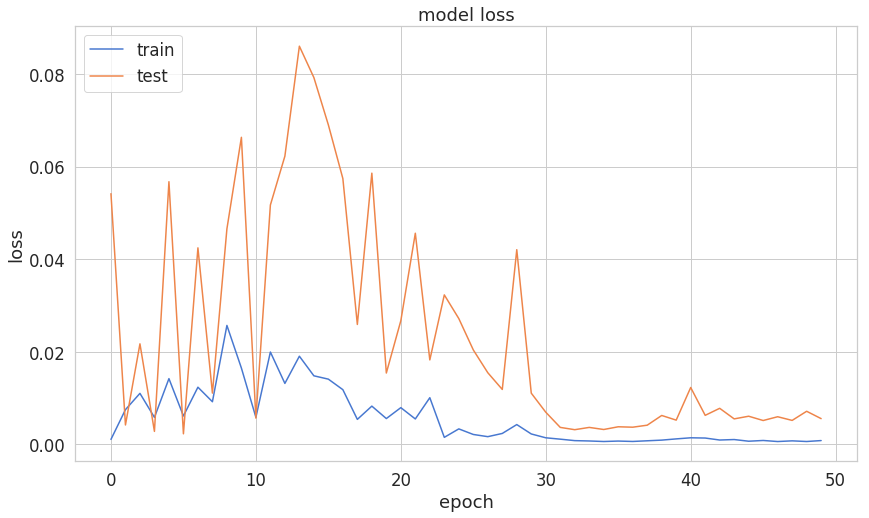

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Prediction

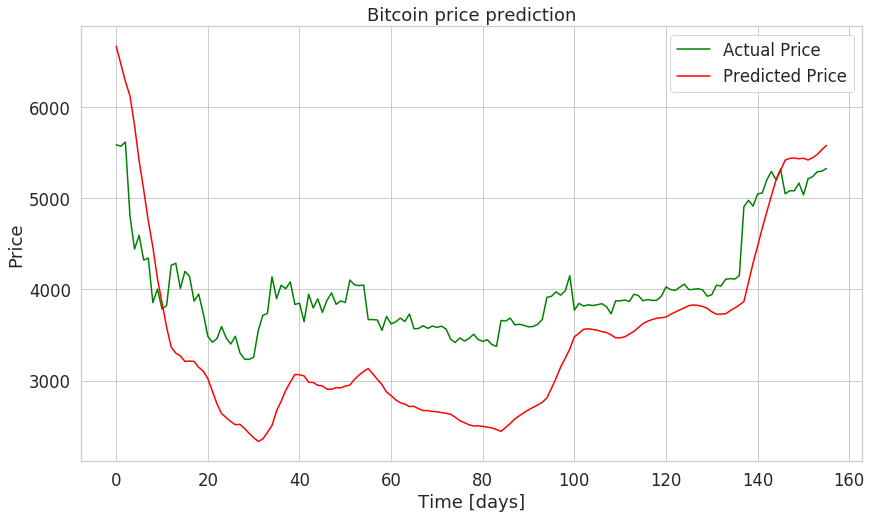

In [0]:
y_hat = model.predict(X_test)

y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)
 
plt.plot(y_test_inverse, label="Actual Price", color='green')
plt.plot(y_hat_inverse, label="Predicted Price", color='red')
 
plt.title('Bitcoin price prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')
 
plt.show();